In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *
from models import RobustPCANN

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pytorch_robust_pca import *

# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Tracking
from tqdm import trange

import sympy
import sympytorch

from TorchCoder import *

Running Python 3.9.6
You can use npar for np.array


In [2]:
# Loading the KS sol
DATA_PATH = "../deephpms_data/KS_simple3.pkl"
data = pickle_load(DATA_PATH)
t = data['t']
x = data['x']
X, T = np.meshgrid(x, t)
Exact = data['u'].T
u_star = Exact.T.flatten()[:,None]

Loaded from ../deephpms_data/KS_simple3.pkl


In [3]:
# Adding noise
noise_intensity = 1
u_star_clean = u_star
noise = perturb(u_star, intensity=noise_intensity, noise_type="normal", overwrite=False)
u_star = u_star + noise
print("Perturbed u_star with intensity =", float(noise_intensity))

print("Running Robust PCA on u_star")
rpca = R_pca_numpy(u_star)
u_star_L, u_star_S = rpca.fit(tol=1e-16, max_iter=10000, iter_print=100, verbose=False)
print('Robust PCA Loss:', mean_squared_error(u_star, u_star_L+u_star_S))

Perturbed u_star with intensity = 1.0
Running Robust PCA on u_star
Robust PCA Loss: 1.5089494224175295e-34


In [4]:
((noise-u_star_S)**2).mean()

0.7954338229620993

In [5]:
out, _, PSD = fft1d_denoise(to_tensor(u_star), thres=None, c=0)
out = out.detach().numpy()
PSD = PSD.detach().numpy()
fft_noise = u_star-out

In [6]:
print(((noise-(u_star-out))**2).mean())
print(F.kl_div(torch.tensor(u_star-out), torch.tensor(noise)).item())

0.33210165397314806
-0.25377807137311775


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [7]:
import seaborn as sns

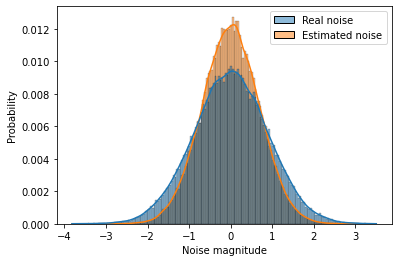

In [8]:
# noise_intensity = 0.01 -> Noise magitude ranges from -0.4 to around 0.6.
tmp = {"Real noise":noise.flatten(), "Estimated noise":(u_star-out).flatten()}
sns.histplot(tmp, kde=True, stat="probability")
plt.xlabel("Noise magnitude")
plt.show()

In [9]:
encoded, decoded, final_loss = QuickEncode(u_star.tolist(), embedding_dim=2)

epoch : 100, loss_mean : 1.6722881
epoch : 200, loss_mean : 1.4757013
epoch : 300, loss_mean : 1.1023389
epoch : 400, loss_mean : 0.6510507
epoch : 500, loss_mean : 0.3088342
epoch : 600, loss_mean : 0.1523472
epoch : 700, loss_mean : 0.0521809
epoch : 800, loss_mean : 0.0194361
epoch : 900, loss_mean : 0.0074445
epoch : 1000, loss_mean : 0.0033238
epoch : 1100, loss_mean : 0.0018668
epoch : 1200, loss_mean : 0.0012208
epoch : 1300, loss_mean : 0.0008733
epoch : 1400, loss_mean : 0.0006603
epoch : 1500, loss_mean : 0.0005175
epoch : 1600, loss_mean : 0.0004154
epoch : 1700, loss_mean : 0.0003389
epoch : 1800, loss_mean : 0.0002798
Early Stopping activated. Final validation loss : 0.0002836


In [10]:
lstm_noise = (u_star - decoded.reshape(-1, 1).numpy())
((noise-lstm_noise)**2).mean()

0.7975064228001871

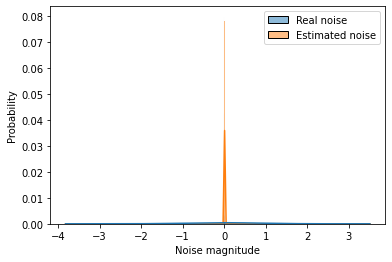

In [11]:
tmp = {"Real noise":noise.flatten(), "Estimated noise":(lstm_noise).flatten()}
sns.histplot(tmp, kde=True, stat="probability")
plt.xlabel("Noise magnitude")
plt.show()

In [13]:
print(kl_normal(fft_noise, u_star))
print(kl_normal(lstm_noise, u_star))

0.25597813725471497
3.816368579864502


Some goals + Notes
    
    - Is denoising using FFT better than the Robust PCA algo for init?: YES!
    - If so, what is the recommended c wrt the varied noise_intensity?: With noise_intensity = 10, the c=1 starts to perform better. So c=0 is quite good for a wide range of noises.
    
    - noise_intensity = 10 -> c=1 best, noise_intensity = 0.01 -> c=-1 best, noise_intensity = 1 -> c=0 best. If the medium level of noise is presumed, the c=0 is recommended starting point!
    
    - In practice, the c hyper-parameter can be easily tuned wrt to the the first-epochs loss.
    
    - Using fft is sometimes better than knowing only the noise dist.
    
    - Sparse noise is easier to be captured by the FFT than typical normal-distributed noise.